<a href="https://colab.research.google.com/github/tranthanhtra/transformer-webui/blob/main/Copy_of_transformer_Import.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu May 27 19:04:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip -q install torchtext==0.6.0
! pip -q install pyvi 
! pip -q install https://github.com/trungtv/vi_spacy/raw/master/packages/vi_spacy_model-0.2.1/dist/vi_spacy_model-0.2.1.tar.gz
! python -m spacy link vi_spacy_model vi_spacy_model

import nltk
nltk.download('wordnet')


✘ Link 'vi_spacy_model' already exists
To overwrite an existing link, use the --force flag

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import os
import math

In [4]:
!pip install flask-ngrok



In [5]:
from flask import Flask
from flask_ngrok import run_with_ngrok



In [6]:
app = Flask(__name__)
run_with_ngrok(app)

# Embedding Layer with Position Encoding


In [7]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        
        self.embed = nn.Embedding(vocab_size, d_model)
        
    def forward(self, x):
        return self.embed(x)
    
# Embedder(100, 512)(torch.LongTensor([1,2,3,4])).shape

# Position encoding


In [8]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_length=200, dropout=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(max_seq_length, d_model)
        
        # Bảng pe mình vẽ ở trên 
        for pos in range(max_seq_length):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/d_model)))
                pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/d_model)))
        pe = pe.unsqueeze(0)        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        
        x = x*math.sqrt(self.d_model)
        seq_length = x.size(1)
        
        pe = Variable(self.pe[:, :seq_length], requires_grad=False)
        
        if x.is_cuda:
            pe.cuda()
        # cộng embedding vector với pe 
        x = x + pe
        x = self.dropout(x)
        
        return x
    
# PositionalEncoder(512)(torch.rand(5, 30, 512)).shape

# Encoder

In [9]:
def attention(q, k, v, mask=None, dropout=None):
    """
    q: batch_size x head x seq_length x d_model
    k: batch_size x head x seq_length x d_model
    v: batch_size x head x seq_length x d_model
    mask: batch_size x 1 x 1 x seq_length
    output: batch_size x head x seq_length x d_model
    """

    # attention score được tính bằng cách nhân q với k
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)
    
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask==0, -1e9)
    # xong rồi thì chuẩn hóa bằng softmax
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
    
    output = torch.matmul(scores, v)
    return output, scores

# attention(torch.rand(32, 8, 30, 512), torch.rand(32, 8, 30, 512), torch.rand(32, 8, 30, 512)).shape

# Multi Head Attention

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        assert d_model % heads == 0
        
        self.d_model = d_model
        self.d_k = d_model//heads
        self.h = heads
        self.attn = None

        # tạo ra 3 ma trận trọng số là q_linear, k_linear, v_linear như hình trên
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        """
        q: batch_size x seq_length x d_model
        k: batch_size x seq_length x d_model
        v: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        bs = q.size(0)
        # nhân ma trận trọng số q_linear, k_linear, v_linear với dữ liệu đầu vào q, k, v 
        # ở bước encode các bạn lưu ý rằng q, k, v chỉ là một (xem hình trên)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # tính attention score
        scores, self.attn = attention(q, k, v, mask, self.dropout)
        
        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)
        
        output = self.out(concat)
        return output

# MultiHeadAttention(8, 512)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 30, 512)).shape

# Residuals Connection và Normalization Layer



In [11]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        
        self.eps = eps
    
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [12]:
class FeedForward(nn.Module):
    """ Trong kiến trúc của chúng ta có tầng linear 
    """
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
    
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

In [13]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        """
        x: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        
        
        x2 = self.norm_1(x)
        # tính attention value, các bạn để ý q, k, v là giống nhau        
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

# EncoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32 , 1, 30)).shape

# Decoder With Masked Multi Head Attention

In [14]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        """
        x: batch_size x seq_length x d_model
        e_outputs: batch_size x seq_length x d_model
        src_mask: batch_size x 1 x seq_length
        trg_mask: batch_size x 1 x seq_length
        """
        # Các bạn xem hình trên, kiến trúc mình vẽ với code ở chỗ này tương đương nhau.
        x2 = self.norm_1(x)
        # multihead attention thứ nhất, chú ý các từ ở target 
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        # masked mulithead attention thứ 2. k, v là giá trị output của mô hình encoder
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x
    
# DecoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 1, 30), torch.rand(32, 1, 30)).shape

# Cài đặt Encoder
bao gồm N encoder layer

In [15]:
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    """Một encoder có nhiều encoder layer nhé !!!
    """
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
        
    def forward(self, src, mask):
        """
        src: batch_size x seq_length
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

# Encoder(232, 512,6,8,0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 1, 30)).shape

# Cài đặt Decoder
bao gồm N decoder layers

In [16]:
class Decoder(nn.Module):
    """Một decoder có nhiều decoder layer nhé !!!
    """
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        """
        trg: batch_size x seq_length
        e_outputs: batch_size x seq_length x d_model
        src_mask: batch_size x 1 x seq_length
        trg_mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)
    
# Decoder(232, 512, 6, 8, 0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 30, 512), torch.rand(32, 1, 30), torch.rand(32, 1, 30)).shape 

# Cài đặt Transformer 
bao gồm encoder và decoder

In [17]:
class Transformer(nn.Module):
    """ Cuối cùng ghép chúng lại với nhau để được mô hình transformer hoàn chỉnh
    """
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        """
        src: batch_size x seq_length
        trg: batch_size x seq_length
        src_mask: batch_size x 1 x seq_length
        trg_mask batch_size x 1 x seq_length
        output: batch_size x seq_length x vocab_size
        """
        e_outputs = self.encoder(src, src_mask)
        
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output
    
# Transformer(232, 232, 512, 6, 8, 0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.LongTensor(32, 30).random_(0, 10),torch.rand(32, 1, 30),torch.rand(32, 1, 30)).shape

Chúng ta sử dụng torchtext để load dữ liệu, giúp giảm thời gian và hiệu quả 

In [18]:
from torchtext import data

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [19]:

def nopeak_mask(size, device):
    """Tạo mask được sử dụng trong decoder để lúc dự đoán trong quá trình huấn luyện
     mô hình không nhìn thấy được các từ ở tương lai
    """
    np_mask = np.triu(np.ones((1, size, size)),
    k=1).astype('uint8')
    np_mask =  Variable(torch.from_numpy(np_mask) == 0)
    np_mask = np_mask.to(device)
    
    return np_mask

def create_masks(src, trg, src_pad, trg_pad, device):
    """ Tạo mask cho encoder, 
    để mô hình không bỏ qua thông tin của các kí tự PAD do chúng ta thêm vào 
    """
    src_mask = (src != src_pad).unsqueeze(-2)

    if trg is not None:
        trg_mask = (trg != trg_pad).unsqueeze(-2)
        size = trg.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size, device)
        if trg.is_cuda:
            np_mask.cuda()
        trg_mask = trg_mask & np_mask
        
    else:
        trg_mask = None
    return src_mask, trg_mask

In [20]:
from nltk.corpus import wordnet
import re

def get_synonym(word, SRC):
    syns = wordnet.synsets(word)
    for s in syns:
        for l in s.lemmas():
            if SRC.vocab.stoi[l.name()] != 0:
                return SRC.vocab.stoi[l.name()]
            
    return 0

def multiple_replace(dict, text):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text) 

In [21]:
def init_vars(src, model, SRC, TRG, device, k, max_len):
    """ Tính toán các ma trận cần thiết trong quá trình translation sau khi mô hình học xong
    """
    init_tok = TRG.vocab.stoi['<sos>']
    src_mask = (src != SRC.vocab.stoi['<pad>']).unsqueeze(-2)

    # tính sẵn output của encoder 
    e_output = model.encoder(src, src_mask)
    
    outputs = torch.LongTensor([[init_tok]])
    
    outputs = outputs.to(device)
    
    trg_mask = nopeak_mask(1, device)
    # dự đoán kí tự đầu tiên
    out = model.out(model.decoder(outputs,
    e_output, src_mask, trg_mask))
    out = F.softmax(out, dim=-1)
    
    probs, ix = out[:, -1].data.topk(k)
    log_scores = torch.Tensor([math.log(prob) for prob in probs.data[0]]).unsqueeze(0)
    
    outputs = torch.zeros(k, max_len).long()
    outputs = outputs.to(device)
    outputs[:, 0] = init_tok
    outputs[:, 1] = ix[0]
    
    e_outputs = torch.zeros(k, e_output.size(-2),e_output.size(-1))
   
    e_outputs = e_outputs.to(device)
    e_outputs[:, :] = e_output[0]
    
    return outputs, e_outputs, log_scores

def k_best_outputs(outputs, out, log_scores, i, k):
    
    probs, ix = out[:, -1].data.topk(k)
    log_probs = torch.Tensor([math.log(p) for p in probs.data.view(-1)]).view(k, -1) + log_scores.transpose(0,1)
    k_probs, k_ix = log_probs.view(-1).topk(k)
    
    row = k_ix // k
    col = k_ix % k

    outputs[:, :i] = outputs[row, :i]
    outputs[:, i] = ix[row, col]

    log_scores = k_probs.unsqueeze(0)
    
    return outputs, log_scores

def beam_search(src, model, SRC, TRG, device, k, max_len):    

    outputs, e_outputs, log_scores = init_vars(src, model, SRC, TRG, device, k, max_len)
    eos_tok = TRG.vocab.stoi['<eos>']
    src_mask = (src != SRC.vocab.stoi['<pad>']).unsqueeze(-2)
    ind = None
    for i in range(2, max_len):
    
        trg_mask = nopeak_mask(i, device)

        out = model.out(model.decoder(outputs[:,:i],
        e_outputs, src_mask, trg_mask))

        out = F.softmax(out, dim=-1)
    
        outputs, log_scores = k_best_outputs(outputs, out, log_scores, i, k)
        
        ones = (outputs==eos_tok).nonzero() # Occurrences of end symbols for all input sentences.
        sentence_lengths = torch.zeros(len(outputs), dtype=torch.long).cuda()
        for vec in ones:
            i = vec[0]
            if sentence_lengths[i]==0: # First end symbol has not been found yet
                sentence_lengths[i] = vec[1] # Position of first end symbol

        num_finished_sentences = len([s for s in sentence_lengths if s > 0])

        if num_finished_sentences == k:
            alpha = 0.7
            div = 1/(sentence_lengths.type_as(log_scores)**alpha)
            _, ind = torch.max(log_scores * div, 1)
            ind = ind.data[0]
            break
    
    if ind is None:
        
        length = (outputs[0]==eos_tok).nonzero()[0] if len((outputs[0]==eos_tok).nonzero()) > 0 else -1
        return ' '.join([TRG.vocab.itos[tok] for tok in outputs[0][1:length]])
    
    else:
        length = (outputs[ind]==eos_tok).nonzero()[0]
        return ' '.join([TRG.vocab.itos[tok] for tok in outputs[ind][1:length]])

In [22]:
def translate_sentence(sentence, model, SRC, TRG, device, k, max_len):
    """Dịch một câu sử dụng beamsearch
    """
    model.eval()
    indexed = []
    sentence = SRC.preprocess(sentence)
    
    for tok in sentence:
        if SRC.vocab.stoi[tok] != SRC.vocab.stoi['<eos>']:
            indexed.append(SRC.vocab.stoi[tok])
        else:
            indexed.append(get_synonym(tok, SRC))
    
    sentence = Variable(torch.LongTensor([indexed]))
    
    sentence = sentence.to(device)
    
    sentence = beam_search(sentence, model, SRC, TRG, device, k, max_len)

    return  multiple_replace({' ?' : '?',' !':'!',' .':'.','\' ':'\'',' ,':','}, sentence)

In [23]:
import spacy
import re

class tokenize(object):
    
    def __init__(self, lang):
        self.nlp = spacy.load(lang)
            
    def tokenizer(self, sentence):
        sentence = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
        sentence = re.sub(r"[ ]+", " ", sentence)
        sentence = re.sub(r"\!+", "!", sentence)
        sentence = re.sub(r"\,+", ",", sentence)
        sentence = re.sub(r"\?+", "?", sentence)
        sentence = sentence.lower()
        return [tok.text for tok in self.nlp.tokenizer(sentence) if tok.text != " "]

## Data loader
Sử dụng torchtext để load dữ liệu nhanh chóng

In [24]:
import os
import dill as pickle
import pandas as pd

def read_data(src_file, trg_file):
    src_data = open(src_file).read().strip().split('\n')

    trg_data = open(trg_file).read().strip().split('\n')
 
    return src_data, trg_data

def create_fields(src_lang, trg_lang):
    
    print("loading spacy tokenizers...")
    
    t_src = tokenize(src_lang)
    t_trg = tokenize(trg_lang)

    TRG = data.Field(lower=True, tokenize=t_trg.tokenizer, init_token='<sos>', eos_token='<eos>')
    SRC = data.Field(lower=True, tokenize=t_src.tokenizer)
        
    return SRC, TRG

def create_dataset(src_data, trg_data, max_strlen, batchsize, device, SRC, TRG, istrain=True):

    print("creating dataset and iterator... ")

    raw_data = {'src' : [line for line in src_data], 'trg': [line for line in trg_data]}
    df = pd.DataFrame(raw_data, columns=["src", "trg"])
    
    mask = (df['src'].str.count(' ') < max_strlen) & (df['trg'].str.count(' ') < max_strlen)
    df = df.loc[mask]

    df.to_csv("translate_transformer_temp.csv", index=False)
    
    data_fields = [('src', SRC), ('trg', TRG)]
    train = data.TabularDataset('./translate_transformer_temp.csv', format='csv', fields=data_fields)

    train_iter = MyIterator(train, batch_size=batchsize, device=device,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=istrain, shuffle=True)
    
    os.remove('translate_transformer_temp.csv')
    
    if istrain:
        SRC.build_vocab(train)
        TRG.build_vocab(train)

    return train_iter


In [25]:
def step(model, optimizer,batch, criterion):
    """
    Một lần cập nhật mô hình
    """
    model.train()
    
    src = batch.src.transpose(0,1).cuda()
    trg = batch.trg.transpose(0,1).cuda()
    trg_input = trg[:, :-1]
    src_mask, trg_mask = create_masks(src, trg_input, src_pad, trg_pad, opt['device'])
    preds = model(src, trg_input, src_mask, trg_mask)

    ys = trg[:, 1:].contiguous().view(-1)

    optimizer.zero_grad()
    loss = criterion(preds.view(-1, preds.size(-1)), ys)
    loss.backward()
    optimizer.step_and_update_lr()
    
    loss = loss.item()
    
    return loss    

In [26]:
def validiate(model, valid_iter, criterion):
    """ Tính loss trên tập validation
    """
    model.eval()
    
    with torch.no_grad():
        total_loss = []
        for batch in valid_iter:
            src = batch.src.transpose(0,1).cuda()
            trg = batch.trg.transpose(0,1).cuda()
            trg_input = trg[:, :-1]
            src_mask, trg_mask = create_masks(src, trg_input, src_pad, trg_pad, opt['device'])
            preds = model(src, trg_input, src_mask, trg_mask)

            ys = trg[:, 1:].contiguous().view(-1)
            
            loss = criterion(preds.view(-1, preds.size(-1)), ys)
            
            loss = loss.item()
            
            total_loss.append(loss)
        
    avg_loss = np.mean(total_loss)
    
    return avg_loss

# Optimizer
Để huấn luyện mô hình transformer, các bạn vẫn sử dụng Adam, tuy nhiên, learning rate cần phải được điều chỉnh trong suốt quá trình học theo công thức sau

![alt text](https://raw.githubusercontent.com/pbcquoc/pbcquoc.github.io/master/images/transformer/optimizer.png)

![alt text](https://pbcquoc.github.io/images/transformer/opt.png)


In [27]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, init_lr, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.init_lr = init_lr
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))

    def state_dict(self):
        optimizer_state_dict = {
            'init_lr':self.init_lr,
            'd_model':self.d_model,
            'n_warmup_steps':self.n_warmup_steps,
            'n_steps':self.n_steps,
            '_optimizer':self._optimizer.state_dict(),
        }
        
        return optimizer_state_dict
    
    def load_state_dict(self, state_dict):
        self.init_lr = state_dict['init_lr']
        self.d_model = state_dict['d_model']
        self.n_warmup_steps = state_dict['n_warmup_steps']
        self.n_steps = state_dict['n_steps']
        
        self._optimizer.load_state_dict(state_dict['_optimizer'])
        
    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

# Label Smoothing




In [28]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, padding_idx, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.padding_idx = padding_idx

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 2))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx, as_tuple=False)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)
            
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [29]:
from torchtext.data.metrics import bleu_score

def bleu(valid_src_data, valid_trg_data, model, SRC, TRG, device, k, max_strlen):
    pred_sents = []
    for sentence in valid_src_data:
        pred_trg = translate_sentence(sentence, model, SRC, TRG, device, k, max_strlen)
        pred_sents.append(pred_trg)
    
    pred_sents = [TRG.preprocess(sent) for sent in pred_sents]
    trg_sents = [[sent.split()] for sent in valid_trg_data]
    
    return bleu_score(pred_sents, trg_sents)

In [30]:
opt = {
    'train_src_data':'./data/train.en',
    'train_trg_data':'./data/train.vi',
    'valid_src_data':'./data/tst2013.en',
    'valid_trg_data':'./data/tst2013.vi',
    'src_lang':'en',
    'trg_lang':'en',#'vi_spacy_model',
    'max_strlen':160,
    'batchsize':1500,
    'device':'cuda',
    'd_model': 512,
    'n_layers': 6,
    'heads': 8,
    'dropout': 0.1,
    'lr':0.0001,
    'epochs':30,
    'printevery': 200,
    'k':5,
}

In [31]:
os.makedirs('./data/', exist_ok=True)
! gdown --id 1Fuo_ALIFKlUvOPbK5rUA5OfAS2wKn_95
! gdown --id 1KUkzqG8mdxIDEGYW84UJJUuZB2lcs7sD
! gdown --id 17669ho3c27IxHyF3tIQFENJeXMcoYIG8

Downloading...
From: https://drive.google.com/uc?id=1Fuo_ALIFKlUvOPbK5rUA5OfAS2wKn_95
To: /content/en_vi.zip
10.1MB [00:00, 38.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KUkzqG8mdxIDEGYW84UJJUuZB2lcs7sD
To: /content/SRC.Field
155MB [00:01, 106MB/s] 
Downloading...
From: https://drive.google.com/uc?id=17669ho3c27IxHyF3tIQFENJeXMcoYIG8
To: /content/TRG.Field
154MB [00:01, 105MB/s] 


In [32]:
! unzip -o en_vi.zip

Archive:  en_vi.zip
  inflating: data/tst2013.en         
  inflating: data/tst2012.vi         
  inflating: data/train.en           
  inflating: data/tst2013.vi         
  inflating: data/train.vi           
  inflating: data/tst2012.en         


In [33]:
# train_src_data, train_trg_data = read_data(opt['train_src_data'], opt['train_trg_data'])
# valid_src_data, valid_trg_data = read_data(opt['valid_src_data'], opt['valid_trg_data'])

# SRC, TRG = create_fields(opt['src_lang'], opt['trg_lang'])
# train_iter = create_dataset(train_src_data, train_trg_data, opt['max_strlen'], opt['batchsize'], opt['device'], SRC, TRG, istrain=True)
# valid_iter = create_dataset(valid_src_data, valid_trg_data, opt['max_strlen'], opt['batchsize'], opt['device'], SRC, TRG, istrain=False)

In [34]:
import cloudpickle
import types

import dill

dill._dill._reverse_typemap['ClassType'] = type

with open("./SRC.Field", "rb")as f:
    SRC=dill.load(f)
with open("./TRG.Field", "rb")as f:
    TRG=dill.load(f)

In [35]:
! gdown --id 1Ty1bGrd0sCwEqXhsoViCUaNKa3lFwmPH
# model = Transformer(42498, 20340, 512, 6, 8, 0.1)
model = Transformer(len(SRC.vocab), len(TRG.vocab), opt['d_model'], opt['n_layers'], opt['heads'], opt['dropout'])
model.load_state_dict(torch.load('./transformer.pth'))

Downloading...
From: https://drive.google.com/uc?id=1Ty1bGrd0sCwEqXhsoViCUaNKa3lFwmPH
To: /content/transformer.pth
348MB [00:03, 93.4MB/s]


<All keys matched successfully>

In [36]:
# model = Transformer()

# for p in model.parameters():
#     if p.dim() > 1:
#         nn.init.xavier_uniform_(p)

# model = model.to(opt['device'])

In [37]:

# optimizer = ScheduledOptim(
#         torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09),
#         0.2, opt['d_model'], 4000)

# criterion = LabelSmoothingLoss(len(TRG.vocab), padding_idx=trg_pad, smoothing=0.1)

In [38]:
# import time

# for epoch in range(opt['epochs']):
#     total_loss = 0
    
#     for i, batch in enumerate(train_iter): 
#         s = time.time()
#         loss = step(model, optimizer, batch, criterion)
        
#         total_loss += loss
        
#         if (i + 1) % opt['printevery'] == 0:
#             avg_loss = total_loss/opt['printevery']
#             print('epoch: {:03d} - iter: {:05d} - train loss: {:.4f} - time: {:.4f}'.format(epoch, i, avg_loss, time.time()- s))
#             total_loss = 0

#     s = time.time()
#     valid_loss = validiate(model, valid_iter, criterion)
#     bleuscore = bleu(valid_src_data[:500], valid_trg_data[:500], model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
#     print('epoch: {:03d} - iter: {:05d} - valid loss: {:.4f} - bleu score: {:.4f} - time: {:.4f}'.format(epoch, i, valid_loss, bleuscore, time.time() - s))
    

In [39]:
# bleu(valid_src_data, valid_trg_data, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])

In [40]:
model = model.to(opt['device'])
model.eval()

Transformer(
  (encoder): Encoder(
    (embed): Embedder(
      (embed): Embedding(42498, 512)
    )
    (pe): PositionalEncoder(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.

In [41]:
from flask import request, render_template

In [42]:
import seaborn
import matplotlib.pyplot as plt
from pylab import savefig

def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax, annot=False)

In [43]:
import base64
from io import BytesIO

In [44]:
@app.route("/", methods=['POST', 'GET'])
def submit():
    if request.method == 'POST':
        inp = request.form.get('src-sentence')
        sentence = inp
        trans_sent = translate_sentence(sentence, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])

        sent = SRC.preprocess(sentence)

        encodedList = []

        for layer in range(1, 6, 2):
          tmpfile = BytesIO()
          fig, axs = plt.subplots(1,4, figsize=(20, 10))
          print("Encoder Layer", layer+1)
          for h in range(4):
            draw(model.encoder.layers[layer].attn.attn[0, h].data.cpu(), 
                  sent, sent if h ==0 else [], ax=axs[h])
          #fig.tight_layout()
          plt.tight_layout()
          fig.savefig(tmpfile, format='png')
          encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
          encodedList.append(encoded)

        trg_sent = ['<sos>'] + TRG.preprocess(trans_sent)
        decodedList = []

        for layer in range(1, 6, 2):
          tmpfile = BytesIO()
          fig, axs = plt.subplots(1,4, figsize=(20, 10))
          print("Decoder Self Layer", layer+1)
          for h in range(4):
            draw(model.decoder.layers[layer].attn_1.attn[0, h].data[:len(trg_sent), :len(trg_sent)].cpu(), 
                  trg_sent, trg_sent if h ==0 else [], ax=axs[h])
          fig.tight_layout()
          fig.savefig(tmpfile, format='png')
          decoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
          decodedList.append(decoded)
          
          print("Decoder Src Layer", layer+1)
          fig, axs = plt.subplots(1,4, figsize=(20, 10))
          for h in range(4):
            draw(model.decoder.layers[layer].attn_2.attn[0, h].data[:len(trg_sent), :len(sent)].cpu(), 
                  sent, trg_sent if h ==0 else [], ax=axs[h])
          fig.tight_layout()
          fig.savefig(tmpfile, format='png')
          decoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
          decodedList.append(decoded)
        return render_template('form.html', dest=trans_sent, decList=decodedList, encList=encodedList, plot=True)
    
    return render_template('form.html')

In [45]:
# model = model.to(opt['device'])
# model.eval()
# sentence= inp
# trans_sent = translate_sentence(sentence, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
# trans_sent

In [46]:
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://7cd9f6250fef.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


[2021-05-27 19:05:37,484] ERROR in app: Exception on / [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-44-26f1bdc75af1>", line 51, in submit
    return render_template('form.html')
  File "/usr/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Visualize

In [ ]:
import seaborn
import matplotlib.pyplot as plt

def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax, annot=False)

# Visualize Encoder
Dùng heatmap để visualize giá trị attention sẽ cho chúng ta biết khi encode một câu mô hình chú ý từ gì ở lân cận

Encoder Layer 2


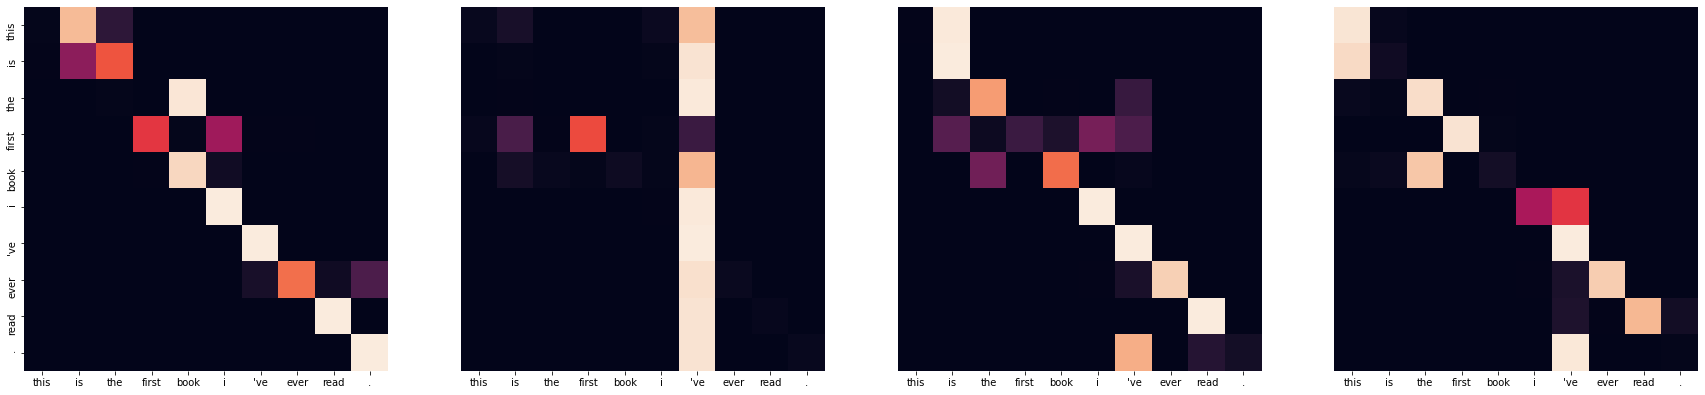

Encoder Layer 4


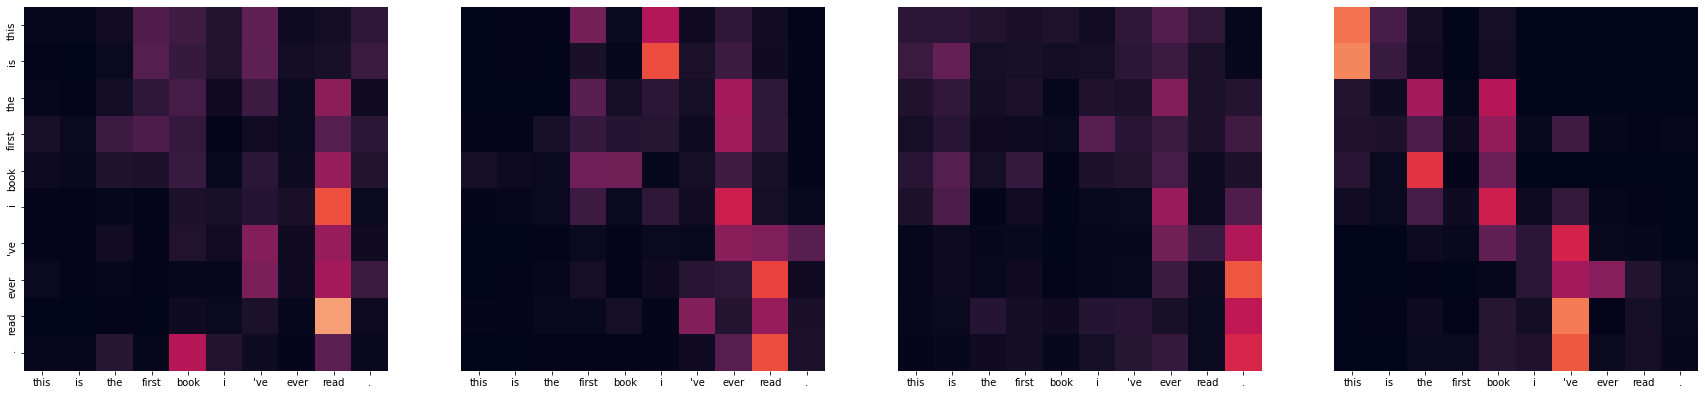

Encoder Layer 6


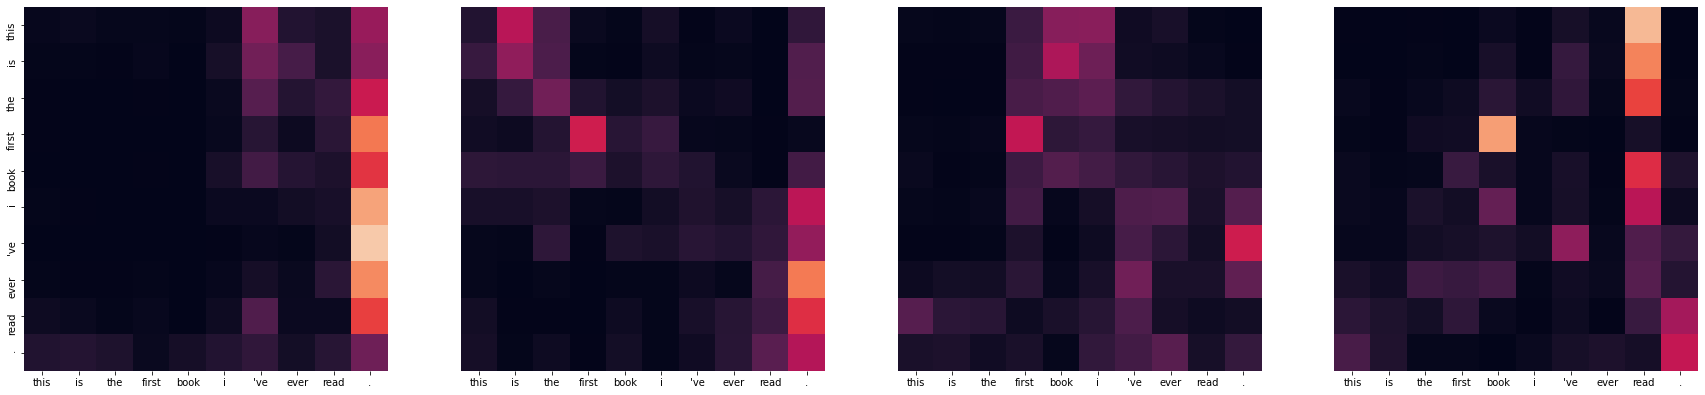

In [ ]:
sent = SRC.preprocess(sentence)

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(30, 15))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].attn.attn[0, h].data.cpu(), 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()

# Visualize Decoder
Ở decoder, các bạn có 2 loại visualization
* self attention: giá trị attention khi mô hình decoder mã hóa câu đích lúc dịch
* src attention: giá trị attention khi mô hình decoder sử dụng câu src

Decoder Self Layer 2


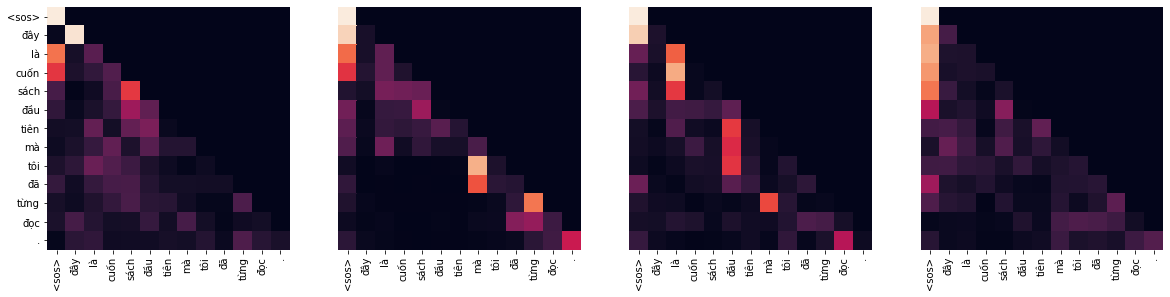

Decoder Src Layer 2


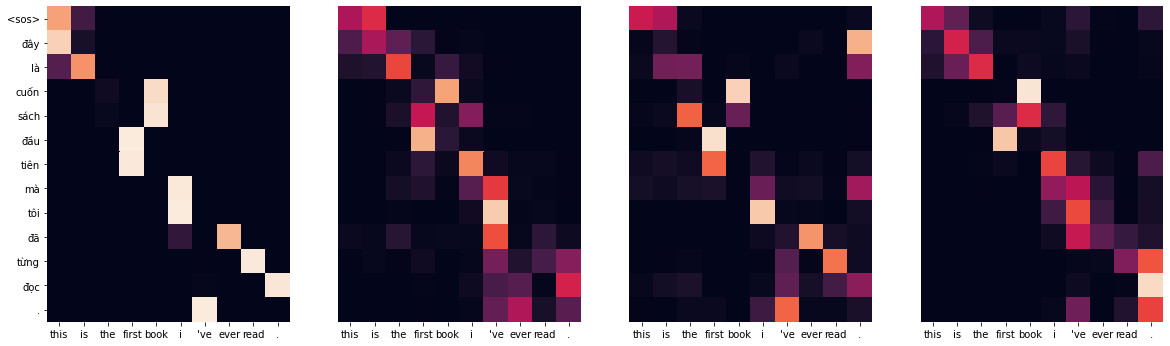

Decoder Self Layer 4


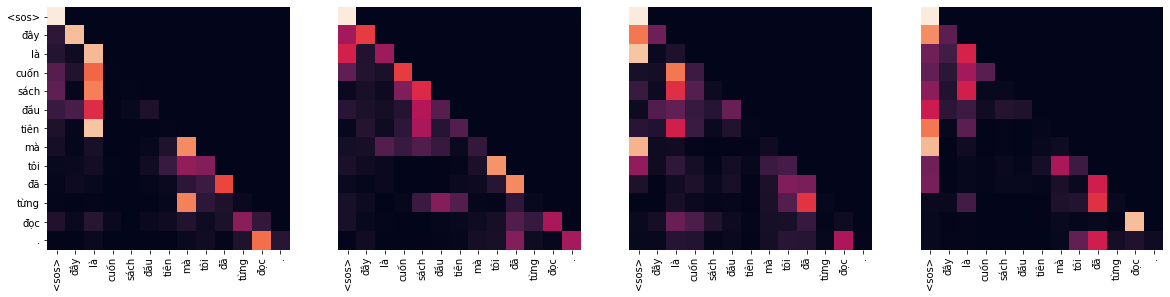

Decoder Src Layer 4


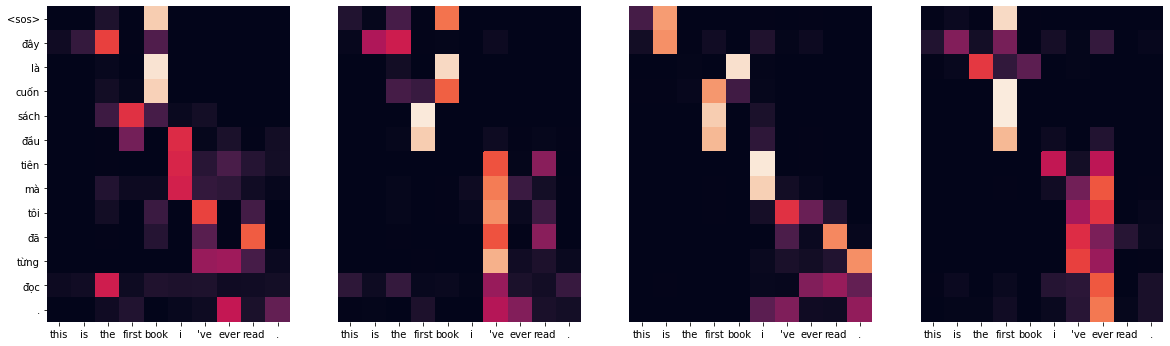

Decoder Self Layer 6


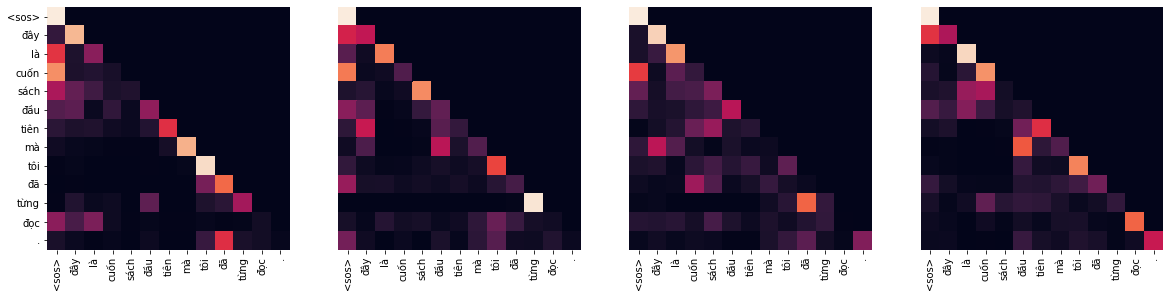

Decoder Src Layer 6


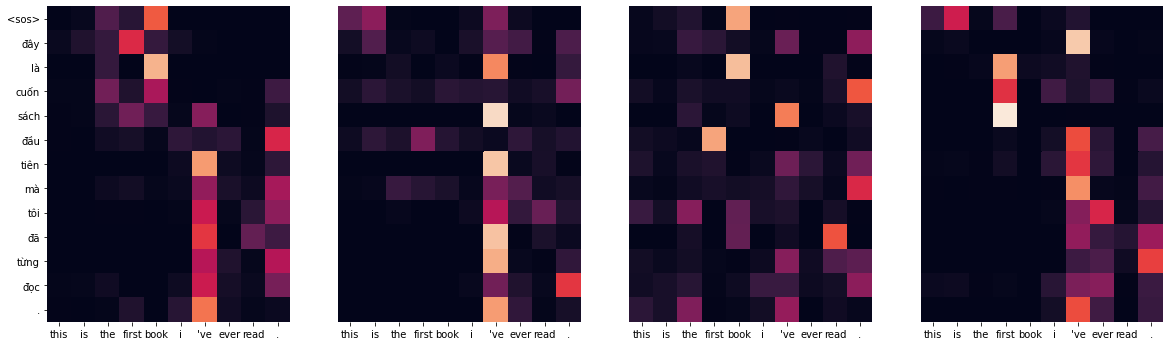

In [ ]:
trg_sent = ['<sos>'] + TRG.preprocess(trans_sent)

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].attn_1.attn[0, h].data[:len(trg_sent), :len(trg_sent)].cpu(), 
            trg_sent, trg_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].attn_2.attn[0, h].data[:len(trg_sent), :len(sent)].cpu(), 
            sent, trg_sent if h ==0 else [], ax=axs[h])
    plt.show()